In [1]:
import pandas as pd
import json
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import json
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
import string
import spacy
from surprise.accuracy import rmse
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score
from math import sqrt
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import transformers
from geopy.distance import geodesic
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.nn.functional import softmax
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split


/opt/anaconda3/envs/CAC_Labs/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Baixar recursos do NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/martapereira/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/martapereira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/martapereira/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/martapereira/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
def load_yelp_data(file_path, nrows=None):
    data = []
    print(f" Loading: {file_path}...")  

    with open(file_path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if nrows and i >= nrows:
                break
            data.append(json.loads(line))
            
            if (i + 1) % 100000 == 0:
                print(f"  🔄 {i + 1} loaded lines...")

    print(f" {file_path} loaded with {len(data)} lines!\n")  
    return pd.DataFrame(data)

print("\n Starting to load datasets...\n")




 Starting to load datasets...



In [4]:

df_business = load_yelp_data("data/yelp_academic_dataset_business.json")  # (~150K)
df_review = load_yelp_data("data/sparks_reviews.json")  # 500K
df_user = load_yelp_data("data/yelp_academic_dataset_user.json")  # 500k
#df_checkin = pd.read_json('data/yelp_academic_dataset_checkin.json', lines=True) not used for now
#df_tip = pd.read_json('data/yelp_academic_dataset_tip.json', lines=True) not used for now

 Loading: data/yelp_academic_dataset_business.json...
  🔄 100000 loaded lines...
 data/yelp_academic_dataset_business.json loaded with 150346 lines!

 Loading: data/sparks_reviews.json...
 data/sparks_reviews.json loaded with 40186 lines!

 Loading: data/yelp_academic_dataset_user.json...
  🔄 100000 loaded lines...
  🔄 200000 loaded lines...
  🔄 300000 loaded lines...
  🔄 400000 loaded lines...
  🔄 500000 loaded lines...
  🔄 600000 loaded lines...
  🔄 700000 loaded lines...
  🔄 800000 loaded lines...
  🔄 900000 loaded lines...
  🔄 1000000 loaded lines...
  🔄 1100000 loaded lines...
  🔄 1200000 loaded lines...
  🔄 1300000 loaded lines...
  🔄 1400000 loaded lines...
  🔄 1500000 loaded lines...
  🔄 1600000 loaded lines...
  🔄 1700000 loaded lines...
  🔄 1800000 loaded lines...
  🔄 1900000 loaded lines...
 data/yelp_academic_dataset_user.json loaded with 1987897 lines!




## Restaurants in Spark city

In [5]:
df_review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,LkXdUnLG55HUqClm5C-FRQ,Bcwv94u7FgNCpCoJLmSsaA,l4aS1QVy_bGnwUXSJzpbsw,5.0,0,0,1,Best pizza ever... hands down.\n\nLove the pee...,2009-08-04 22:21:20
1,Z_tQ-hruQRU45Rg3XglyJQ,9wymgENHBBOm9Tlx7xHy7A,HZtkTPfSshfRjpQR7x1Raw,2.0,0,0,0,I didn't really like my sandwich I got here. I...,2014-03-14 23:13:32
2,r34W_h6NEMvBIpT2h53GQw,p0tP-O8y7rhJKd1iFirgwQ,t0XZeA0MP0P66QyLQn_NUw,5.0,0,0,0,This is a must get when you come to Reno is Ye...,2016-07-15 07:24:31
3,P6Kbftcn5GwvIo2xQyXFBg,fSR8LJJ0Aa3w8HoaGyXYCA,UX3eq0WsVva-cqlVrzyzFg,5.0,0,0,0,"Yummy food, they will veganize things for you...",2013-12-28 22:22:19
4,wXcsMgO27jDlr_8xuhn-pQ,CqRAt1eogaHCBBtF_shemg,ruFtZKwlJASx5BTk1dh5AQ,5.0,0,0,0,The new Bacon-Bleu cheeseburger is excellent! ...,2010-03-14 05:14:25


In [6]:
df_restaurants = df_business[df_business['categories'].str.contains('Restaurants', na=False)]
df_restaurants = df_restaurants.reset_index(drop=True)
# sparks
df_restaurants = df_restaurants[df_restaurants['business_id'].isin(df_review['business_id'])]
df_restaurants = df_restaurants.reset_index(drop=True)
df_restaurants.shape


(334, 14)

In [7]:
df_user = df_user[df_user['user_id'].isin(df_review['user_id'])]


In [8]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

## DATA EXPLORATORY ANALISIS 
### Different Type of Businesses and their Count

<Axes: >

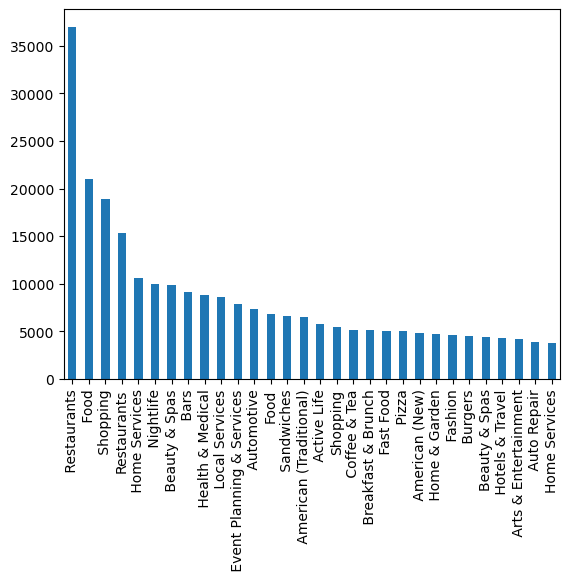

In [ ]:
uniq_cat_dict = {}
for i in df_business['categories']:
    cat = str(i).split(',')
    for j in cat:
        if j not in uniq_cat_dict.keys():
            uniq_cat_dict[j] = 1
        else:
            uniq_cat_dict[j] += 1
uniq_cat_series = pd.Series(uniq_cat_dict)
uniq_cat_series.sort_values(ascending = False, inplace = True)
uniq_cat_series[:30].plot(kind = 'bar')

In [ ]:
df_restaurants.head(5)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Lx8ZYUJ_-3Aa8N821mN1WQ,ALM Kainan,"390 N McCarran Blvd, Ste B",Sparks,NV,89434,39.537179,-119.735532,4.0,13,0,"{'RestaurantsAttire': 'u'casual'', 'HasTV': 'F...","Restaurants, Filipino","{'Monday': '10:0-19:0', 'Tuesday': '10:0-19:0'..."
1,UX3eq0WsVva-cqlVrzyzFg,Cantina Los Tres Hombres,926 Victorian Ave,Sparks,NV,89431,39.535111,-119.754857,3.0,284,1,"{'HasTV': 'True', 'RestaurantsPriceRange2': '2...","Bars, Nightlife, Mexican, Restaurants, Seafood","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'..."
2,YhQAQhG1IkXJH7oLZMbM9w,Del Taco,252 Los Altos Pkwy,Sparks,NV,89431,39.583653,-119.740935,1.5,60,1,"{'RestaurantsGoodForGroups': 'True', 'GoodForK...","Restaurants, Fast Food, Mexican","{'Monday': '8:0-23:0', 'Tuesday': '8:0-23:0', ..."
3,qbPsfIKJZQAlrPaYmSyZuQ,All Wrapped Up,,Sparks,NV,89431,39.540154,-119.748395,4.0,7,1,"{'RestaurantsDelivery': 'False', 'GoodForMeal'...","Food Trucks, Food, Salad, Sandwiches, Caterers...",None
4,V4THIJk9uhoxL7f06fK5VA,Roundabout Catering,631 Dunn Cir,Sparks,NV,89431,39.528286,-119.734864,5.0,38,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Caterers, Party Equipment Rentals, Food, Venue...","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ..."


In [ ]:
df_restaurants.shape

(334, 14)

In [ ]:
df_restaurants.describe()

,latitude,longitude,stars,review_count,is_open
count,334.000000,334.000000,334.000000,334.000000,334.000000
mean,39.550736,-119.736836,3.407186,114.386228,0.718563
std,0.025439,0.025591,0.821306,156.482786,0.450375
min,39.520643,-119.813527,1.500000,5.000000,0.000000
25%,39.534481,-119.753786,3.000000,25.250000,0.000000
50%,39.541638,-119.738714,3.500000,60.000000,1.000000
75%,39.556945,-119.719900,4.000000,133.750000,1.000000
max,39.640527,-119.556307,5.000000,1576.000000,1.000000


In [ ]:
df_user.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,13,10,17,3,66,96,119,119,35,18
39,AkBtT43dYcttxQ3qOzPBAg,Sherri,1034,2007-02-20 18:21:07,3066,1485,2235,"2007,2008,2009,2010,2011,2012,2013,2014,2015,2016","Hg1EF9PjGfcKBSNMjvWBeQ, PcPminF0bIUsKjUh9e4DMQ...",114,...,26,24,83,23,229,570,528,528,118,50
55,2l0O1EI1m0yWjFo2zSt71w,Shiho,2837,2005-07-02 01:59:55,19237,9542,15235,"2006,2007,2008,2009,2010,2011","ZxigNlfaGmqtC1CROVu9Dg, XKAFikZAfddYv0Vg1PUkwA...",492,...,108,85,79,40,350,742,1070,1070,403,258
65,YuRfPsIME6v5qYr3GfFzrg,Eric,57,2011-03-18 22:52:43,22,3,3,,"sp4yvAwatFx7gnlqtqNs9Q, lvI1TNSbnw8oAFy6JVswGg...",2,...,0,0,0,0,2,0,0,0,0,0


In [ ]:
df_review.head()
df_review.shape


(40186, 9)

In [ ]:
df_restaurants.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Lx8ZYUJ_-3Aa8N821mN1WQ,ALM Kainan,"390 N McCarran Blvd, Ste B",Sparks,NV,89434,39.537179,-119.735532,4.0,13,0,"{'RestaurantsAttire': 'u'casual'', 'HasTV': 'F...","Restaurants, Filipino","{'Monday': '10:0-19:0', 'Tuesday': '10:0-19:0'..."
1,UX3eq0WsVva-cqlVrzyzFg,Cantina Los Tres Hombres,926 Victorian Ave,Sparks,NV,89431,39.535111,-119.754857,3.0,284,1,"{'HasTV': 'True', 'RestaurantsPriceRange2': '2...","Bars, Nightlife, Mexican, Restaurants, Seafood","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'..."
2,YhQAQhG1IkXJH7oLZMbM9w,Del Taco,252 Los Altos Pkwy,Sparks,NV,89431,39.583653,-119.740935,1.5,60,1,"{'RestaurantsGoodForGroups': 'True', 'GoodForK...","Restaurants, Fast Food, Mexican","{'Monday': '8:0-23:0', 'Tuesday': '8:0-23:0', ..."
3,qbPsfIKJZQAlrPaYmSyZuQ,All Wrapped Up,,Sparks,NV,89431,39.540154,-119.748395,4.0,7,1,"{'RestaurantsDelivery': 'False', 'GoodForMeal'...","Food Trucks, Food, Salad, Sandwiches, Caterers...",None
4,V4THIJk9uhoxL7f06fK5VA,Roundabout Catering,631 Dunn Cir,Sparks,NV,89431,39.528286,-119.734864,5.0,38,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Caterers, Party Equipment Rentals, Food, Venue...","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ..."


In [ ]:
df_review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,LkXdUnLG55HUqClm5C-FRQ,Bcwv94u7FgNCpCoJLmSsaA,l4aS1QVy_bGnwUXSJzpbsw,5.0,0,0,1,Best pizza ever... hands down.\n\nLove the pee...,2009-08-04 22:21:20
1,Z_tQ-hruQRU45Rg3XglyJQ,9wymgENHBBOm9Tlx7xHy7A,HZtkTPfSshfRjpQR7x1Raw,2.0,0,0,0,I didn't really like my sandwich I got here. I...,2014-03-14 23:13:32
2,r34W_h6NEMvBIpT2h53GQw,p0tP-O8y7rhJKd1iFirgwQ,t0XZeA0MP0P66QyLQn_NUw,5.0,0,0,0,This is a must get when you come to Reno is Ye...,2016-07-15 07:24:31
3,P6Kbftcn5GwvIo2xQyXFBg,fSR8LJJ0Aa3w8HoaGyXYCA,UX3eq0WsVva-cqlVrzyzFg,5.0,0,0,0,"Yummy food, they will veganize things for you...",2013-12-28 22:22:19
4,wXcsMgO27jDlr_8xuhn-pQ,CqRAt1eogaHCBBtF_shemg,ruFtZKwlJASx5BTk1dh5AQ,5.0,0,0,0,The new Bacon-Bleu cheeseburger is excellent! ...,2010-03-14 05:14:25


In [ ]:
df_review.shape

(40186, 9)

In [ ]:
df_review.describe()

,stars,useful,funny,cool
count,40186.000000,40186.000000,40186.000000,40186.000000
mean,3.594038,1.277709,0.306574,0.691086
std,1.542312,2.868504,1.315701,2.242514
min,1.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000
75%,5.000000,2.000000,0.000000,1.000000
max,5.000000,217.000000,103.000000,201.000000


In [ ]:
df_user.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,13,10,17,3,66,96,119,119,35,18
39,AkBtT43dYcttxQ3qOzPBAg,Sherri,1034,2007-02-20 18:21:07,3066,1485,2235,"2007,2008,2009,2010,2011,2012,2013,2014,2015,2016","Hg1EF9PjGfcKBSNMjvWBeQ, PcPminF0bIUsKjUh9e4DMQ...",114,...,26,24,83,23,229,570,528,528,118,50
55,2l0O1EI1m0yWjFo2zSt71w,Shiho,2837,2005-07-02 01:59:55,19237,9542,15235,"2006,2007,2008,2009,2010,2011","ZxigNlfaGmqtC1CROVu9Dg, XKAFikZAfddYv0Vg1PUkwA...",492,...,108,85,79,40,350,742,1070,1070,403,258
65,YuRfPsIME6v5qYr3GfFzrg,Eric,57,2011-03-18 22:52:43,22,3,3,,"sp4yvAwatFx7gnlqtqNs9Q, lvI1TNSbnw8oAFy6JVswGg...",2,...,0,0,0,0,2,0,0,0,0,0


In [ ]:
df_user.shape

(20175, 22)

In [ ]:
df_user.describe()

,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
count,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000
mean,48.888625,142.260173,60.979827,98.878017,3.622602,3.611492,6.593507,0.783742,0.564164,0.337447,0.159009,4.442032,12.485056,10.933036,10.933036,3.574275,4.683916
std,222.204144,1775.292759,961.849500,1533.973447,37.408737,1.020159,118.188936,11.053856,14.508433,6.942779,4.124523,62.292047,306.445150,194.252467,194.252467,47.518972,115.609751
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,2.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,11.000000,8.000000,1.000000,2.000000,0.000000,3.790000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,33.000000,32.000000,6.000000,10.000000,1.000000,4.330000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,16978.000000,152979.000000,84992.000000,125516.000000,3642.000000,5.000000,6615.000000,735.000000,1435.000000,464.000000,278.000000,3325.000000,28974.000000,11595.000000,11595.000000,2731.000000,9780.000000


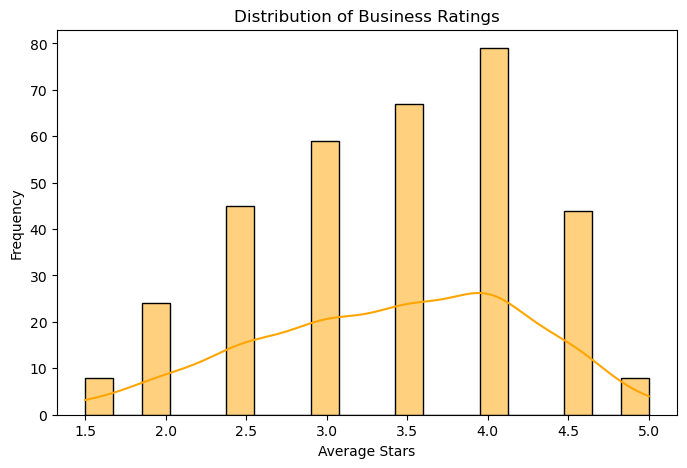

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df_restaurants['stars'], bins=20, kde=True, color="orange")
plt.title("Distribution of Business Ratings")
plt.xlabel("Average Stars")
plt.ylabel("Frequency")
plt.show()


/tmp/ipykernel_5825/3904894633.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_business, x="name", y="review_count", palette="Blues_d")


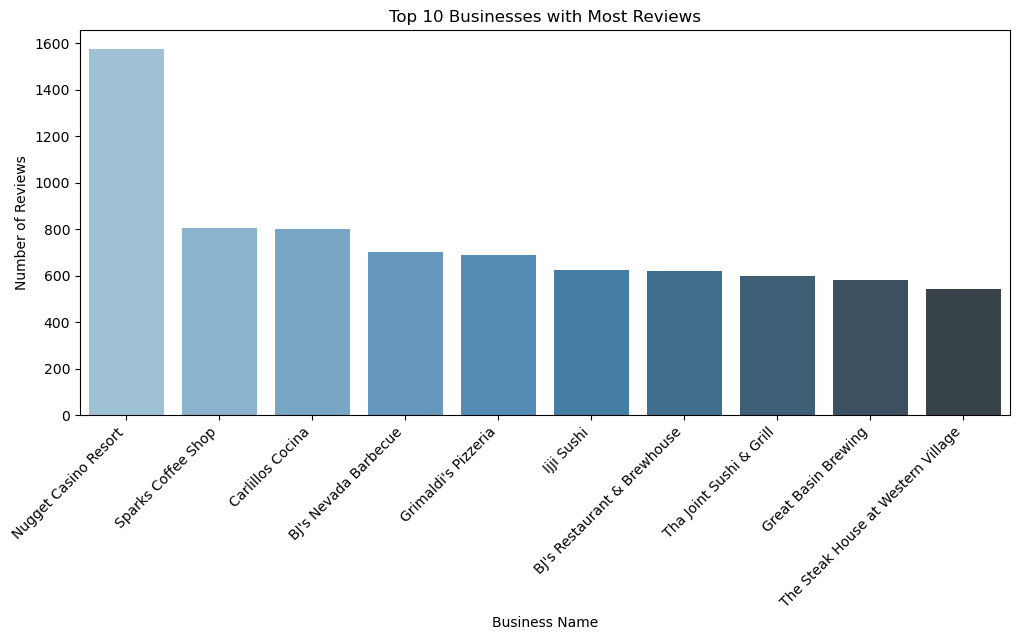

In [ ]:
top_business = df_restaurants.nlargest(10, 'review_count')

plt.figure(figsize=(12, 5))
sns.barplot(data=top_business, x="name", y="review_count", palette="Blues_d")
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Businesses with Most Reviews")
plt.xlabel("Business Name")
plt.ylabel("Number of Reviews")
plt.show()


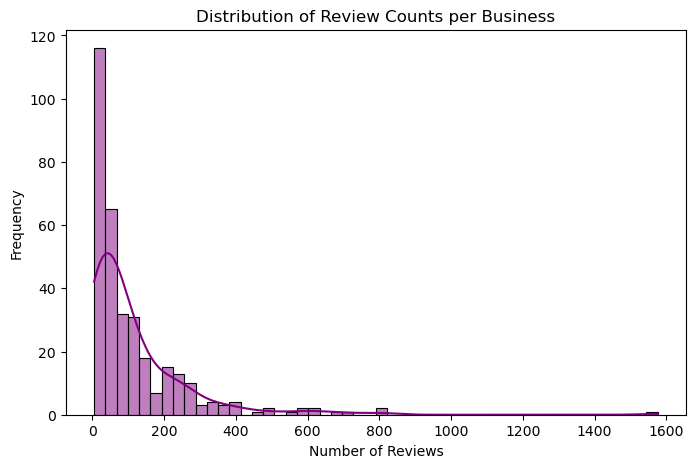

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df_restaurants['review_count'], bins=50, kde=True, color="purple")
plt.title("Distribution of Review Counts per Business")
plt.xlabel("Number of Reviews")
plt.ylabel("Frequency")
#plt.xscale("log") 
plt.show()


/tmp/ipykernel_5825/802102175.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_categories, x="Category", y="Count", palette="coolwarm")


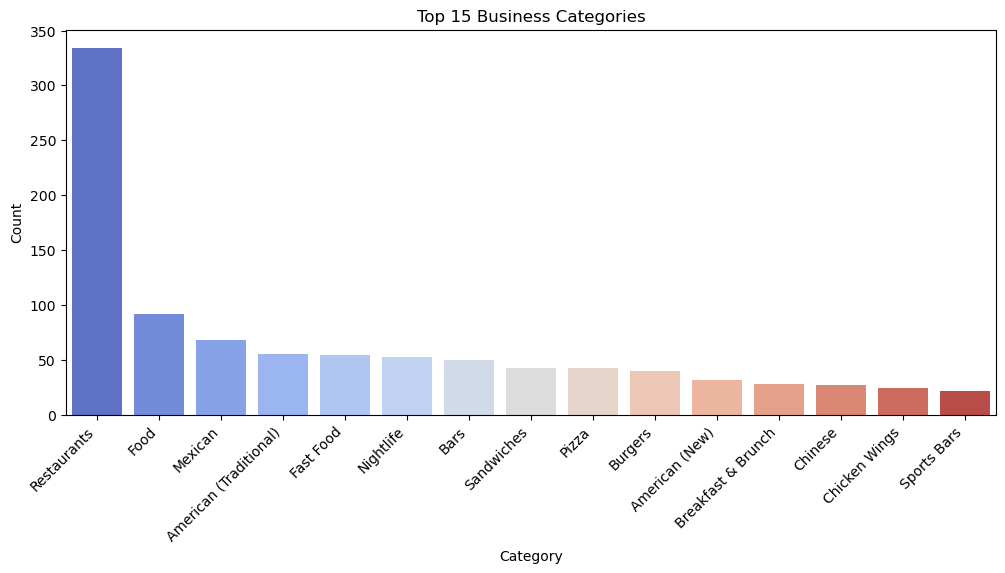

In [ ]:

categories = df_restaurants['categories'].dropna().str.split(', ').explode()
top_categories = pd.DataFrame(Counter(categories).most_common(15), columns=['Category', 'Count'])

plt.figure(figsize=(12, 5))
sns.barplot(data=top_categories, x="Category", y="Count", palette="coolwarm")
plt.xticks(rotation=45, ha="right")
plt.title("Top 15 Business Categories")
plt.show()


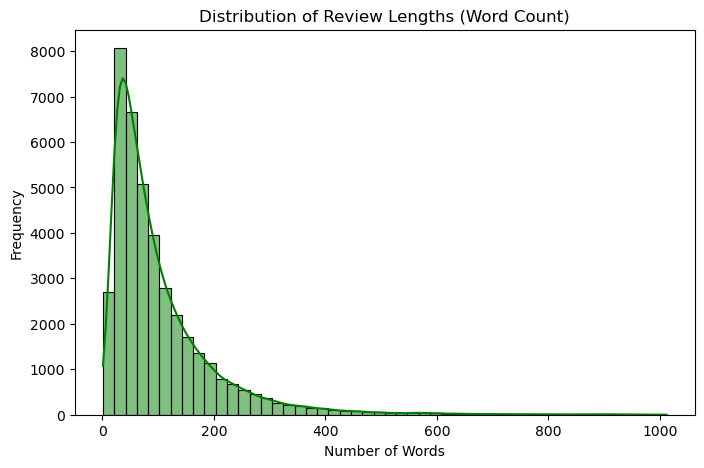

In [ ]:
df_review["review_length"] = df_review["text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 5))
sns.histplot(df_review["review_length"], bins=50, kde=True, color="green")
plt.title("Distribution of Review Lengths (Word Count)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


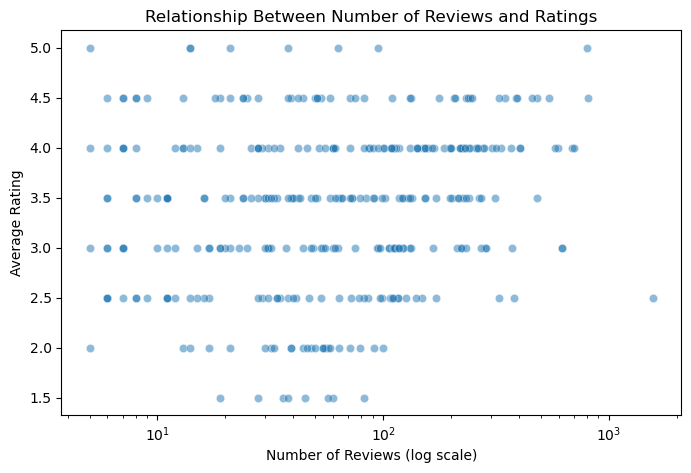

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_restaurants, x="review_count", y="stars", alpha=0.5)
plt.xscale("log")  # Log scale for better visualization
plt.title("Relationship Between Number of Reviews and Ratings")
plt.xlabel("Number of Reviews (log scale)")
plt.ylabel("Average Rating")
plt.show()


/tmp/ipykernel_5825/137038013.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_users, x="user_id", y="review_count", palette="Reds_d")


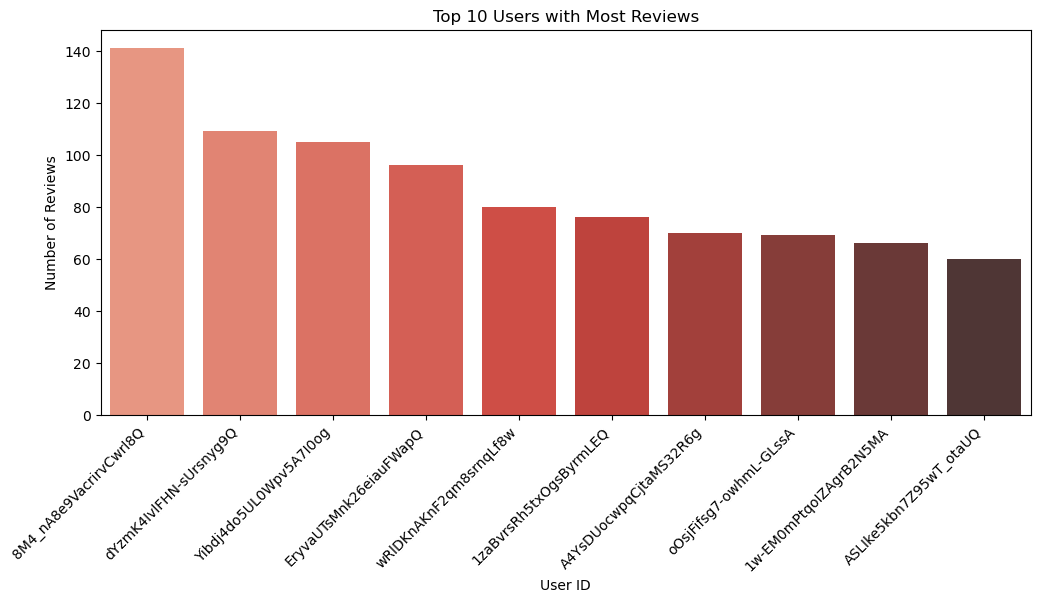

In [ ]:
user_review_counts = df_review["user_id"].value_counts()

# Atualizar o campo review_count no 
df_user["review_count"] = df_user["user_id"].map(user_review_counts).fillna(0).astype(int)
top_users = df_user.nlargest(10, "review_count")

plt.figure(figsize=(12, 5))
sns.barplot(data=top_users, x="user_id", y="review_count", palette="Reds_d")
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Users with Most Reviews")
plt.xlabel("User ID")
plt.ylabel("Number of Reviews")
plt.show()


/tmp/ipykernel_5825/375514905.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_review, x="sentiment", palette="Set1")


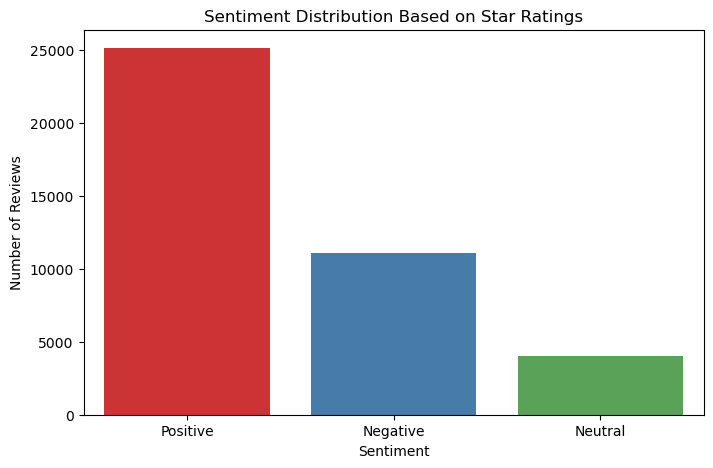

In [ ]:
df_review["sentiment"] = df_review["stars"].apply(lambda x: "Positive" if x >= 4 else "Negative" if x <= 2 else "Neutral")

plt.figure(figsize=(8, 5))
sns.countplot(data=df_review, x="sentiment", palette="Set1")
plt.title("Sentiment Distribution Based on Star Ratings")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()


/tmp/ipykernel_5825/3356107173.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_categories, x="stars", y="categories", palette="viridis")


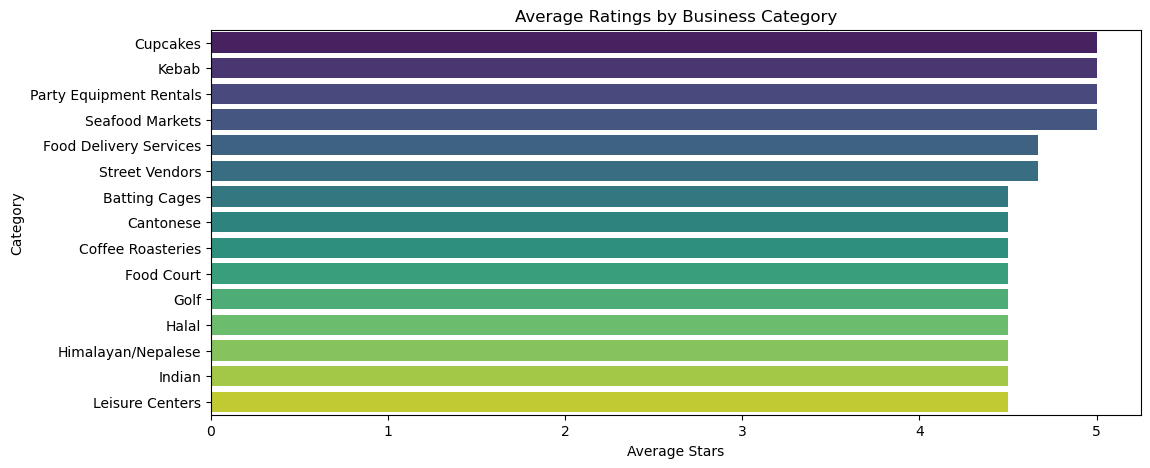

In [ ]:
df_categories = df_restaurants[['categories', 'stars']].dropna()
df_categories = df_categories.assign(categories=df_categories['categories'].str.split(', ')).explode('categories')
df_categories = df_categories.groupby('categories')['stars'].mean().reset_index()
df_categories = df_categories.nlargest(15, 'stars')

plt.figure(figsize=(12, 5))
sns.barplot(data=df_categories, x="stars", y="categories", palette="viridis")
plt.title("Average Ratings by Business Category")
plt.xlabel("Average Stars")
plt.ylabel("Category")
plt.show()


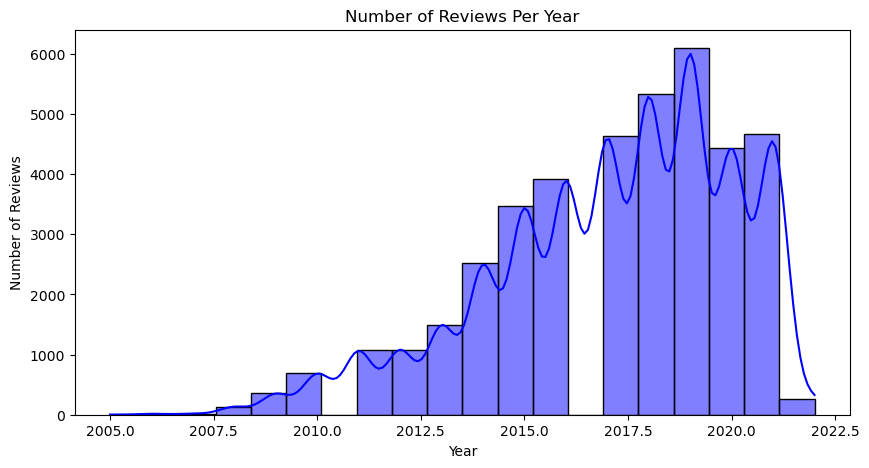

In [ ]:
df_review["year"] = pd.to_datetime(df_review["date"]).dt.year

plt.figure(figsize=(10, 5))
sns.histplot(df_review["year"], bins=20, kde=True, color="blue")
plt.title("Number of Reviews Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Reviews")
plt.show()


## preprocessing

In [ ]:

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])


def preprocess_text(text):
    text = text.lower().strip()  # Lowercase e remover espaços extras

    # Remover caracteres especiais, mas manter números
    text = re.sub(r'[^a-zA-Z0-9 ]', '', text)

    # Tokenização, remoção de stopwords e lematização
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]

    return " ".join(tokens)



In [ ]:
#tqdm.pandas(desc="Processing texts")
#df_review["clean_text"] = df_review["text"].progress_apply(preprocess_text)
#print("\nTexts processed!\n")



### Save preprocessed reviews


In [ ]:
# save processed data
#f_review.to_csv("data/processed_reviews.csv", index=False)
#df_restaurants.to_csv("data/processed_business.csv", index=False)
#df_user.to_csv("data/processed_users.csv", index=False)
#print("\n Data saved!\n")


### Load the processed data


In [ ]:
# load processed data
df_review = pd.read_csv("data/processed_reviews.csv")
df_restaurants = pd.read_csv("data/processed_business.csv")
df_user = pd.read_csv("data/processed_users.csv")
print("\n Data loaded!\n")


 Data loaded!



## Deep Sentiment Analysis 

### Using Bert

In [ ]:
MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
def get_sentiment_score(text):
    if not isinstance(text, str) or text.strip() == "":
        return 0.0  # Neutro para entrada vazia

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(model.device)

    with torch.no_grad():
        outputs = model(**inputs)

    probs = softmax(outputs.logits, dim=1)

    sentiment_score = probs[0][2].item() - probs[0][0].item()

    return sentiment_score


In [ ]:
#df_review["sentiment_score"] = df_review["text"].progress_apply(get_sentiment_score)


In [ ]:
# if sentiment_score > 0.4 then positive, -0.4 < sentiment_score < 0.4 then neutral, sentiment_score < -0.4 then negative
def classify_sentiment(score):
    if score > 0.4:
        return "Positive"
    elif -0.4 < score < 0.4:
        return "Neutral"
    else:
        return "Negative"
df_review["sentiment"] = df_review["sentiment_score"].apply(classify_sentiment)


In [ ]:
# save sentiment 
#df_review.to_csv("data/processed_reviews_sentiment.csv", index=False)
#print("\n Sentiment saved!\n")


 Sentiment saved!



In [ ]:
# load sentiment
df_review = pd.read_csv("data/processed_reviews_sentiment.csv")
print("\n Sentiment loaded!\n") 


 Sentiment loaded!



/tmp/ipykernel_5825/2613134606.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_review, x="sentiment", palette="Set1")


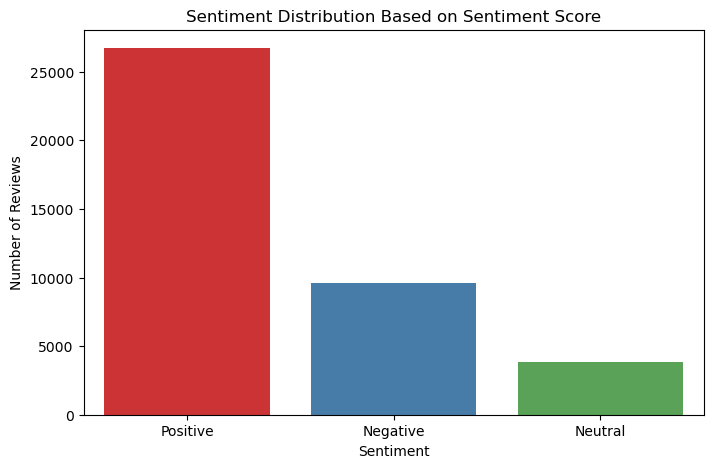

In [ ]:
df_review["sentiment"].value_counts()
plt.figure(figsize=(8, 5))
sns.countplot(data=df_review, x="sentiment", palette="Set1")
plt.title("Sentiment Distribution Based on Sentiment Score")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

#### Sentiment Stars vs BERT Model

In [ ]:
#sentiment score vs stars
df_review["sentiment_stars"] = df_review["stars"].apply(lambda x: "Positive" if x >= 4 else "Negative" if x <= 2 else "Neutral")
df_review["match"] = df_review["sentiment"] == df_review["sentiment_stars"]
accuracy = df_review["match"].mean()
print(f"Accuracy BERT model vs Stars: {accuracy:.2%}")



Accuracy BERT model vs Stars: 84.62%


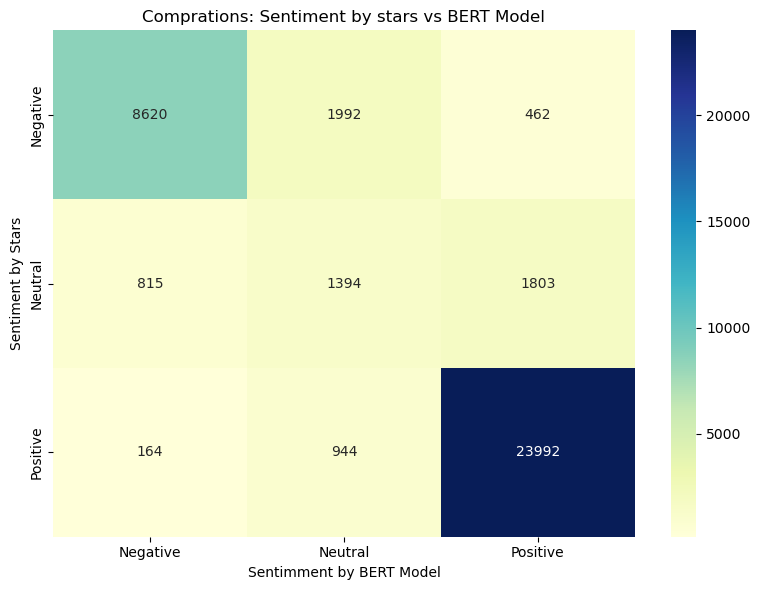

In [ ]:


conf_mat = pd.crosstab(df_review["sentiment_stars"], df_review["sentiment"])

plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Comprations: Sentiment by stars vs BERT Model")
plt.xlabel("Sentimment by BERT Model")
plt.ylabel("Sentiment by Stars")
plt.tight_layout()
plt.show()


## UBCF Implementation with cosine simularity

keep the last review from the user to a specific restaurant 

In [ ]:
df_review = df_review.sort_values("date").drop_duplicates(subset=["user_id", "business_id"], keep="last")


* Matrix with user restaurant interaction

In [ ]:
user_restaurant_matrix = df_review.pivot(index="user_id", columns="business_id", values="adjusted_rating")

* Fill Nan with 0 (users that don't review the restaurant)

In [ ]:
user_restaurant_matrix = user_restaurant_matrix.fillna(0)

* Calculate user similarity with other users

In [ ]:
user_similarity = cosine_similarity(user_restaurant_matrix)

* Pandas dataframe with user's simularity

In [ ]:
user_similarity_df = pd.DataFrame(user_similarity, index=user_restaurant_matrix.index, columns=user_restaurant_matrix.index)

**predict_rating** fucntion predicts the rating a user would give a restaurant based on the nearest neighbors

In [ ]:

def predict_rating(user_id, business_id, k=5):
    
    if business_id not in user_restaurant_matrix.columns:
        return 0  
    
    users_who_rated = user_restaurant_matrix[business_id][user_restaurant_matrix[business_id] > 0].index
    # remove him
    users_who_rated = users_who_rated.difference([user_id])

    similarities = user_similarity_df[user_id].loc[users_who_rated]
    
    top_neighbors = similarities.nlargest(k)
    
    neighbor_ratings = user_restaurant_matrix.loc[top_neighbors.index, business_id]
    # ex (4.0×0.9)+(3.5×0.8)=3.6+2.8=6.4
    # 0.9+0.8=1.7

    if top_neighbors.sum() > 0:
        predicted_rating = np.dot(neighbor_ratings, top_neighbors) / top_neighbors.sum()
    else:
        predicted_rating = 0  
    
    return predicted_rating

#### Evaluation

In [ ]:
df_test = df_review.sample(frac=0.2, random_state=42)  
df_train = df_review.drop(df_test.index)

user_restaurant_matrix_train = df_train.pivot(index="user_id", columns="business_id", values="adjusted_rating").fillna(0)

In [ ]:
true_ratings = []
pred_ratings = []

for _, row in df_test.iterrows():
    user_id = row["user_id"]
    business_id = row["business_id"]
    true_rating = row["adjusted_rating"]
    
    pred_rating = predict_rating(user_id, business_id, k=5)
    
    true_ratings.append(true_rating)
    pred_ratings.append(pred_rating)

rmse = sqrt(mean_squared_error(true_ratings, pred_ratings))
print(f" RMSE: {rmse:.4f}")

mae = mean_absolute_error(true_ratings, pred_ratings)
print(f" MAE: {mae:.4f}")


 RMSE: 0.5174
 MAE: 0.3817


#### Recommender system


In [ ]:
def recommend_user_cf(user_id, top_n=5, include_seen=True):
    if include_seen:
        restaurants = user_restaurant_matrix.columns
    else:
        restaurants = user_restaurant_matrix.columns[user_restaurant_matrix.loc[user_id] == 0]
    recommendations = []

    for business_id in restaurants:
        predicted_rating = predict_rating(user_id, business_id)
        recommendations.append((business_id, predicted_rating))
    
    recommendations.sort(key=lambda x: x[1], reverse=True)
    
    return recommendations[:top_n]

In [ ]:
df_user.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,13,10,17,3,66,96,119,119,35,18
39,AkBtT43dYcttxQ3qOzPBAg,Sherri,1034,2007-02-20 18:21:07,3066,1485,2235,"2007,2008,2009,2010,2011,2012,2013,2014,2015,2016","Hg1EF9PjGfcKBSNMjvWBeQ, PcPminF0bIUsKjUh9e4DMQ...",114,...,26,24,83,23,229,570,528,528,118,50
55,2l0O1EI1m0yWjFo2zSt71w,Shiho,2837,2005-07-02 01:59:55,19237,9542,15235,"2006,2007,2008,2009,2010,2011","ZxigNlfaGmqtC1CROVu9Dg, XKAFikZAfddYv0Vg1PUkwA...",492,...,108,85,79,40,350,742,1070,1070,403,258
65,YuRfPsIME6v5qYr3GfFzrg,Eric,57,2011-03-18 22:52:43,22,3,3,,"sp4yvAwatFx7gnlqtqNs9Q, lvI1TNSbnw8oAFy6JVswGg...",2,...,0,0,0,0,2,0,0,0,0,0


In [ ]:

user_test = '2l0O1EI1m0yWjFo2zSt71w'
print(f" Recommendations for the  {user_test}:")
recommendations = recommend_user_cf(user_test,50,True)


 Recommendations for the  2l0O1EI1m0yWjFo2zSt71w:


In [ ]:
for business_id, predicted_rating in recommendations:
    restaurant = df_restaurants[df_restaurants["business_id"] == business_id]
    
    if not restaurant.empty:
        name = restaurant["name"].values[0]
        city = restaurant["city"].values[0]
        
        print(f" {name} ({city}) -  predicted rating: {predicted_rating:.2f}")

 Del Italy (Sparks) -  predicted rating: 3.01
 Panaderia Azteca Mexico (Sparks) -  predicted rating: 2.87
 Original Thai Restaurant (Sparks) -  predicted rating: 2.37
 Kissho Sushi (Sparks) -  predicted rating: 2.34
 Asuka Sushi (Sparks) -  predicted rating: 2.19
 Tortas Ebenezer (Sparks) -  predicted rating: 2.16
 Pancho & Willie's Cantina (Sparks) -  predicted rating: 2.16
 Taco Bell (Sparks) -  predicted rating: 2.15
 Squeeze In (Sparks) -  predicted rating: 2.11
 Domino's Pizza (Sparks) -  predicted rating: 1.98
 SIU Korean BBQ (Sparks) -  predicted rating: 1.96
 Occidental Taphouse Grill (Sparks) -  predicted rating: 1.95
 Chipotle Mexican Grill (Sparks) -  predicted rating: 1.94
 Manila Hongkong Store & Kitchen (Sparks) -  predicted rating: 1.93
 Candelaria's Mexican Food (Sparks) -  predicted rating: 1.92
 Campo - Sparks (Sparks) -  predicted rating: 1.91
 Beto's Mexican Food (Sparks) -  predicted rating: 1.90
 Manila Bakery & Cafè (Sparks) -  predicted rating: 1.89
 My Favorite

In [ ]:
df_user.shape

(20175, 22)

In [ ]:
users_with_more_than_5_reviews = df_review.groupby("user_id").filter(lambda x: len(x) > 5)["user_id"].unique()
print(f"Users with more than 5 reviews: {len(users_with_more_than_5_reviews)}")


Users with more than 5 reviews: 951


In [ ]:
d

In [ ]:
min_reviews = 10
active_users = df_review['user_id'].value_counts()
df_review_u = df_review[df_review['user_id'].isin(active_users[active_users >= min_reviews].index)]
df_review_u.shape

(6877, 13)

array(['B1OVDsstzC_RaESmtd1oWQ', 'hwzrnwUiqJUHSN_Gmpp4pA',
       '8M4_nA8e9VacrirvCwrl8Q', 'dYzmK4IvlFHN-sUrsnyg9Q',
       'ASLIke5kbn7Z95wT_otaUQ', '1zaBvrsRh5txOgsByrmLEQ',
       'A3t-zNyoXibndG86GbZ8rQ', 'wRlDKnAKnF2qm8srnqLf8w',
       'v23TUA0o89BztD2iYO9DpA', 'Yibdj4do5UL0Wpv5A7I0og',
       'sYZWGe7dOdS1vhzfARGAPA', 'hw5zmHc2QaiO-LCIs5MqHA',
       'gVO3VZwCu54Otc7bUB33Mg'], dtype=object)

In [ ]:
def precision_recall_at_k_optimized(user_ids, k=5, sample_size=100):
    user_ids_sample = np.random.choice(user_ids, size=min(sample_size, len(user_ids)), replace=False)
    precision_list, recall_list = [], []

    for user_id in tqdm(user_ids_sample, desc="Calculating Precision and Recall"):
        relevant_restaurants = set(df_review[(df_review["user_id"] == user_id) & (df_review["adjusted_rating"] > 2)]["business_id"])
        recommended_restaurants = set([r[0] for r in recommend_user_cf(user_id, k, include_seen=True)])

        if not relevant_restaurants:
            continue  

        # Precision@K
        precision = len(recommended_restaurants & relevant_restaurants) / k

        # Recall@K
        recall = len(recommended_restaurants & relevant_restaurants) / len(relevant_restaurants)

        precision_list.append(precision)
        recall_list.append(recall)

    avg_precision = np.mean(precision_list) if precision_list else 0
    avg_recall = np.mean(recall_list) if recall_list else 0

    return avg_precision, avg_recall

avg_precision, avg_recall = precision_recall_at_k_optimized(users_with_more_than_10_reviews, k=5, sample_size=10)

print(f"Precision@5: {avg_precision:.4f}")
print(f"Recall@5: {avg_recall:.4f}")

Calculating Precision and Recall:   0%|          | 0/10 [00:00<?, ?it/s]

Calculating Precision and Recall: 100%|██████████| 10/10 [00:18<00:00,  1.83s/it]

Precision@5: 0.0000
Recall@5: 0.0000


### UBCF implementation with suprise

## Part2 
### Goal: Analyze how a restaurant's reviewer graph evolves over time and predict future trends based on this structure. 

In [29]:
from collections import defaultdict
from itertools import combinations
import networkx as nx

In [41]:
# verificar quantas reviews tem cada restaurante
positive_counts = df_review[df_review["stars"] > 4].groupby("business_id").size().reset_index(name="positive_reviews")
#positive_counts = positive_counts.merge(df_business[["business_id", "name"]], on="business_id", how="left")
positive_counts.sort_values("positive_reviews", ascending=False)

,business_id,positive_reviews
43,8QqnRpM-QxGsjDNuu0E57A,742
223,hjRxa6xpKOwnbUgGvVCE5Q,646
66,CYKj959PZDjweV-CSpssCg,451
229,iwVYwD_5u-JCyplAw9bhfg,405
147,TF3qNGUBUgIYp6u0j79JHQ,367
...,...,...
296,tzSKydKgvXCDp2bzdynoLQ,1
190,b13_FG4ESwrTggA0n7oPPg,1
63,C893a6BzOtWpyJpExAlwNQ,1
136,RBZloeclEkv4HE11CB_rFQ,1


In [50]:
# print all reviews that have stars >= 4.0 do restaurante "YhQAQhG1IkXJH7oLZMbM9w"
rest_id = "iwVYwD_5u-JCyplAw9bhfg"
df_pos = df_review[(df_review["business_id"] == rest_id) & (df_review["stars"] > 4)].copy()
df_pos["date"] = pd.to_datetime(df_pos["date"])
df_pos = df_pos.sort_values("date")
print("Amount of positive reviews", len(df_pos))
# check the mean stars rating
print("Average stars rating:",df_review[df_review["business_id"] == rest_id]["stars"].mean())


Amount of positive reviews 405
Average stars rating: 4.7494736842105265


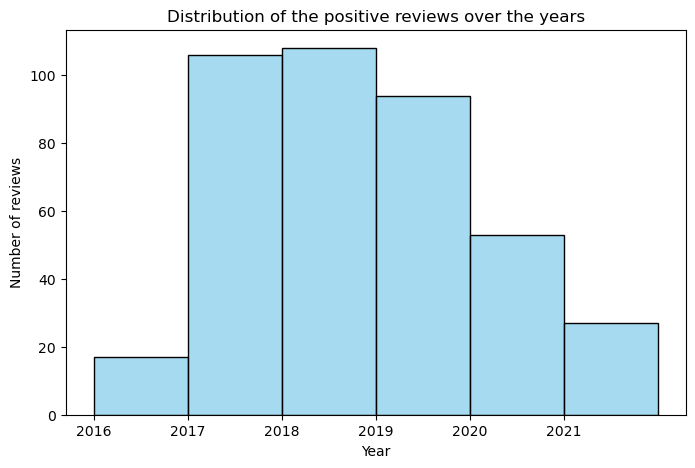

In [46]:
df_pos["year"] = df_pos["date"].dt.year

min_year = df_pos["year"].min()
max_year = df_pos["year"].max()

bins = list(range(min_year, max_year + 2))  # +2 para incluir o último ano como intervalo fechado

plt.figure(figsize=(8, 5))
sns.histplot(df_pos["year"], bins=bins, kde=False, color="skyblue")
plt.xticks(range(min_year, max_year + 1))
plt.title("Distribution of the positive reviews over the years")
plt.xlabel("Year")
plt.ylabel("Number of reviews")
plt.show()

## Social Network Analysis

In [ ]:
df_pos["year"] = df_pos["date"].dt.year
years = sorted(df_pos["year"].unique())

graphs_per_year = {}
edges_per_year = {}

for year in years:
    users_ano = df_pos[df_pos["year"] == year]["user_id"].unique()
    G_year = nx.Graph()
    G_year.add_nodes_from(users_ano)
    for u1, u2 in combinations(users_ano, 2): # faz (A,B) mas nao faz (B,A)
        G_year.add_edge(u1, u2, weight=1)
    graphs_per_year[year] = G_year
    edges_per_year[year] = G_year.number_of_edges()
    print(f"Year {year}: {len(users_ano)} users, {G_year.number_of_edges()} edges")
    


Year 2016: 17 users, 136 edges
Undirected diameter: 1
Weighted undirected diameter: 1
Year 2017: 105 users, 5460 edges
Undirected diameter: 1
Weighted undirected diameter: 1
Year 2018: 106 users, 5565 edges
Undirected diameter: 1
Weighted undirected diameter: 1
Year 2019: 92 users, 4186 edges
Undirected diameter: 1
Weighted undirected diameter: 1
Year 2020: 52 users, 1326 edges
Undirected diameter: 1
Weighted undirected diameter: 1
Year 2021: 25 users, 300 edges
Undirected diameter: 1
Weighted undirected diameter: 1


Closeness - como temos um grafo completo, todos os nos tem o mesmo closeness, porque todos estao a 1 passo dos outros.

Betweeness - indica "nos pontes" que controlam o fluxo de info, betweeness de todos os nós será 0.

### Alternativas a considerar nas ligacoes dos users para dar mais significado:
* Ligar apenas usuários que comentaram no mesmo mês (ou semana)
* Ligar se comentaram em dias proximos

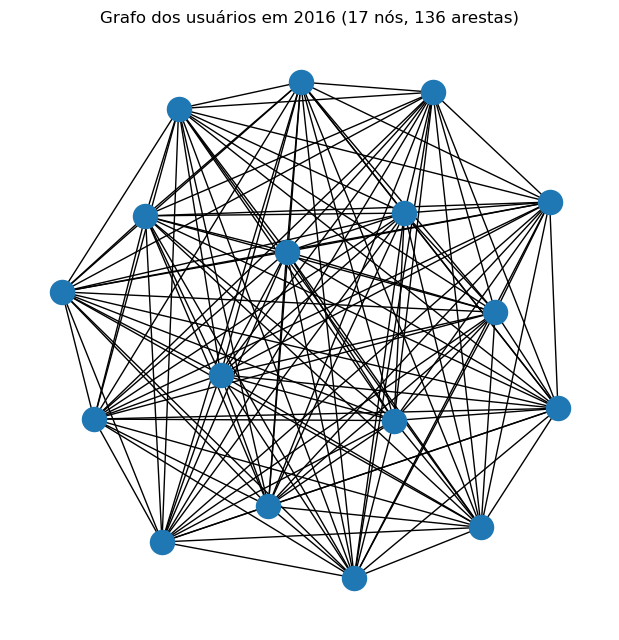

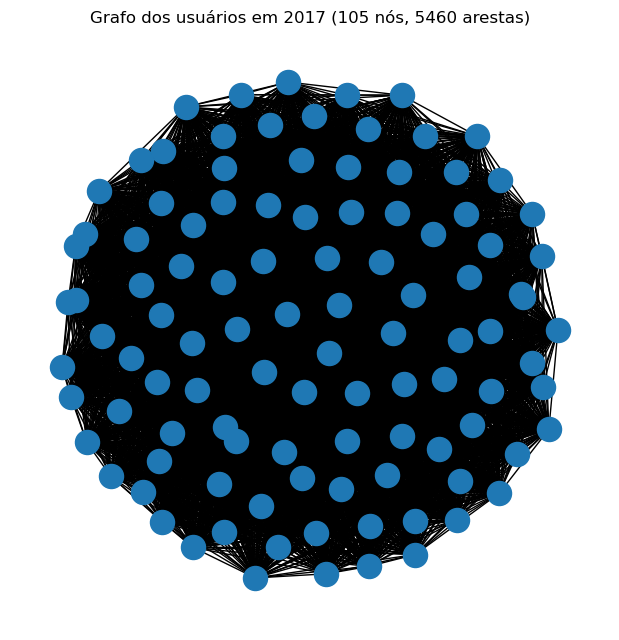

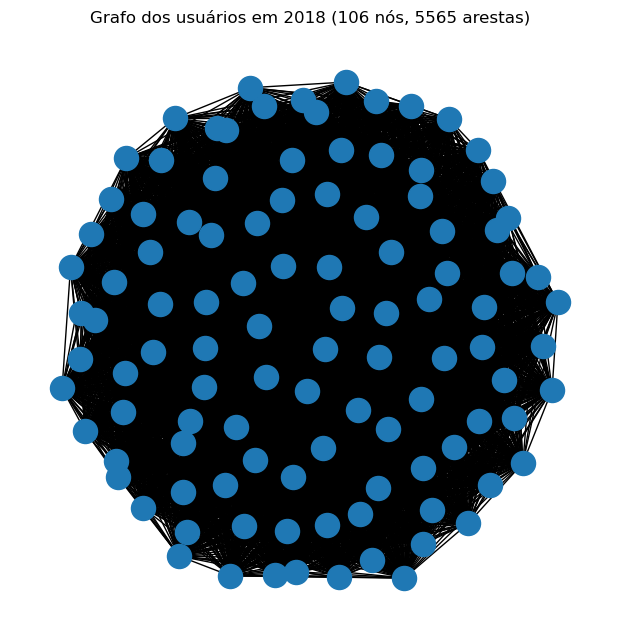

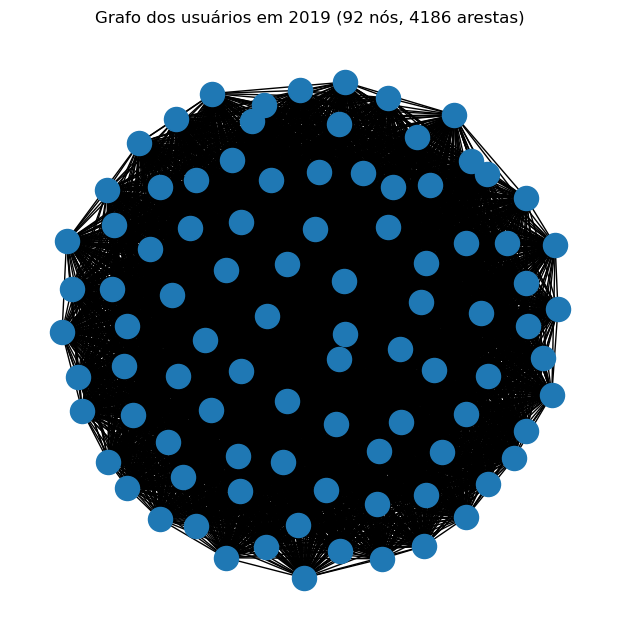

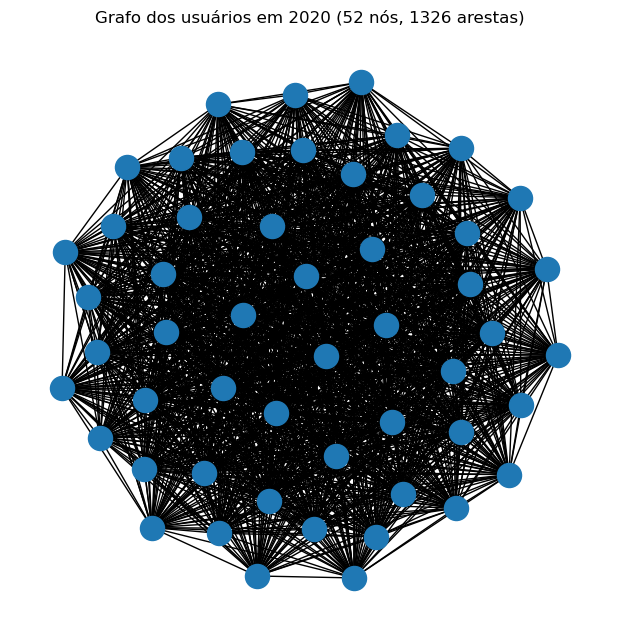

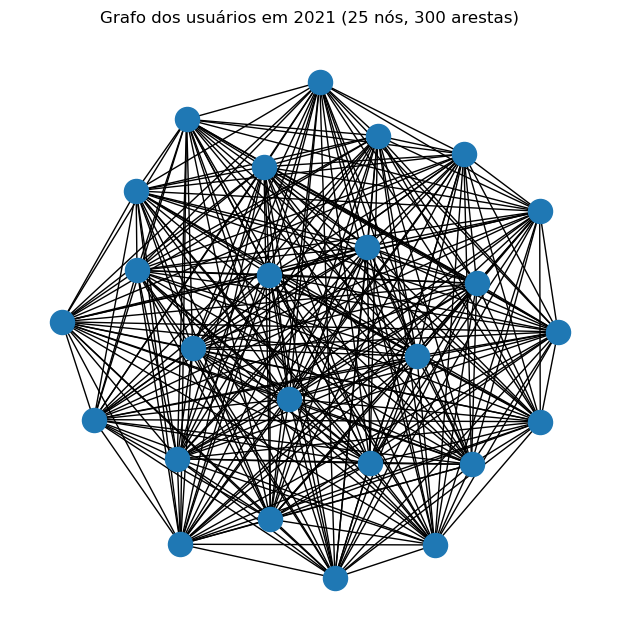

In [ ]:
for year in graphs_per_year:
    G = graphs_per_year[year]
    
    plt.figure(figsize=(6, 6))
    
    nx.draw(G)
    plt.title(f"Grafo dos usuários em {year} ({G.number_of_nodes()} nós, {G.number_of_edges()} arestas)")
    plt.axis('off')
    plt.show()

In [ ]:
# O algoritmo força sempre um corte arbitrario mesmo que o grafo nao tenha comunidades
"""from networkx.algorithms import community

for year, G in graphs_per_year.items():
    # compute the communities
    communities_generator = community.girvan_newman(G)
    
    # since girvan_newman generates the community partitions incrementally, let's grab the final community partitions
    communities = next(communities_generator)

    # assign colors based on the community
    num_communities = len(communities)
    community_colors = {node: i for i, community in enumerate(communities) for node in community}

    plt.figure(figsize=(6, 6))
    pos = nx.spring_layout(G) 

    # Color nodes according to their community
    node_colors = [community_colors[node] for node in G.nodes]
    nx.draw(G, pos, with_labels=True, node_color=node_colors, cmap=plt.cm.rainbow, node_size=300, font_size=8, edge_color='gray')"""

In [ ]:
# pip install python-louvain
import community as community_louvain  

for year, G in graphs_per_year.items():
    partition = community_louvain.best_partition(G)
    num_communities = len(set(partition.values()))
    print(f"Ano {year}: {num_communities} comunidades")


Ano 2016: 1 comunidades
Ano 2017: 1 comunidades
Ano 2018: 1 comunidades
Ano 2019: 1 comunidades
Ano 2020: 1 comunidades
Ano 2021: 1 comunidades


### Prever o numero de reviews por ano

In [ ]:
! pip install statsmodels

2022-01-01    13.519145
2023-01-01     8.637292
2024-01-01     6.561446
Freq: YS-JAN, Name: predicted_mean, dtype: float64


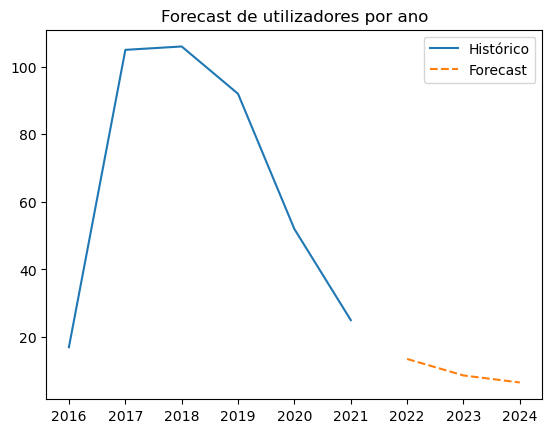

'\n2022-01-01    13.519145\n2023-01-01     8.637292\n2024-01-01     6.561446\n'

In [84]:
from statsmodels.tsa.arima.model import ARIMA

users_per_year = {}
for year in years:
    users_per_year[year] = len(graphs_per_year[year].nodes())

ts = pd.Series(users_per_year)
ts.index = pd.to_datetime(ts.index, format='%Y')
ts = ts.asfreq('YS')

model = ARIMA(ts, order=(1, 1, 0)) #(p,d,q)
model_fit = model.fit()

forecast = model_fit.forecast(steps=3)
print(forecast)

plt.plot(ts, label='Histórico')
plt.plot(forecast, label='Forecast', linestyle='--')
plt.title("Forecast de utilizadores por ano")
plt.legend()
plt.show()

"""
2022-01-01    13.519145
2023-01-01     8.637292
2024-01-01     6.561446
"""

Verificar estacionaridade, pois o ARIMA exige que a serie seja estacionaria (media e variancia constantes)

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts)
print('Estatística ADF:', result[0])
print('p-valor:', result[1])
print('Valores críticos:', result[4])

""" (1,1,0)
Estatística ADF: -0.2108162467904974
p-valor: 0.9372200088440067
Valores críticos: {'1%': -7.355440625, '5%': -4.474365000000001, '10%': -3.1269325}
"""

Estatística ADF: -0.2108162467904974
p-valor: 0.9372200088440067
Valores críticos: {'1%': -7.355440625, '5%': -4.474365000000001, '10%': -3.1269325}


### future work: In order to have a bigger series, divide data into months of each year for example

## experimentar regression model 